# Import Packages

In [1]:
import sys
sys.path.append('..')
import pandas as pd
import utils
from sklearn.metrics import mean_squared_error
import numpy as np
from isoweek import Week
import math
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import pickle
import matplotlib.pyplot as plt


# Settings

In [2]:
path_models = utils.get_project_root() + '/03_Forecasting_LightGBM/models/'

forecast_horizon = 1

n_splits = 1

target_variable = 'Turnover' # Either 'Turnover' or 'Sales_QTY'

# Import Sales Data

In [3]:
query = 'SELECT * FROM `globus-datahub-dev.Verteiler_PoC.timeseries_sales_weekly` where Year <= 2019 OR (Year = 2020 AND Week <= 47) order by sku, site_id, year, week'
df_raw = utils.bq_to_dataframe(
    query, verbose=True).pipe(utils.reduce_memory_usage)

********************
Query Duration:  0:05:21.000148
Mem. usage decreased to 1901.85 Mb (13.8% reduction)


In [4]:
df = df_raw.copy()
df

,Week,Year,Date,Site_ID,SKU,Sales_QTY,Turnover,Season_Year,Vendor_ID,Vendor_Name,...,Warengruppe_ID,Warengruppe_Desc,Subclass_Desc,Class_Desc,Web_Article,Web_Article_From,Web_Article_To,CENSHARE_CAT_1,CENSHARE_CAT_2,CENSHARE_CAT_3
0,4,2010,2010W4,101,1014557,4.0,103.599998,9999,0000126656,Schwarz Kitchen Selection SA,...,721,Küche,Zerkleinern,Kuechenhelfer,X,2015-01-28,9999-12-31,Kuche,Kuchenmesser,wiegemesser
1,5,2010,2010W5,101,1014557,1.0,25.900000,9999,0000126656,Schwarz Kitchen Selection SA,...,721,Küche,Zerkleinern,Kuechenhelfer,X,2015-01-28,9999-12-31,Kuche,Kuchenmesser,wiegemesser
2,6,2010,2010W6,101,1014557,2.0,51.799999,9999,0000126656,Schwarz Kitchen Selection SA,...,721,Küche,Zerkleinern,Kuechenhelfer,X,2015-01-28,9999-12-31,Kuche,Kuchenmesser,wiegemesser
3,7,2010,2010W7,101,1014557,0.0,0.000000,9999,0000126656,Schwarz Kitchen Selection SA,...,721,Küche,Zerkleinern,Kuechenhelfer,X,2015-01-28,9999-12-31,Kuche,Kuchenmesser,wiegemesser
4,8,2010,2010W8,101,1014557,0.0,0.000000,9999,0000126656,Schwarz Kitchen Selection SA,...,721,Küche,Zerkleinern,Kuechenhelfer,X,2015-01-28,9999-12-31,Kuche,Kuchenmesser,wiegemesser
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10332825,47,2020,2020W47,101,1289328500,4.0,56.090000,9999,0000948934,HAY ApS,...,988,Wohnboutique,Wohnaccessoires,HAY,X,2021-02-25,9999-12-31,Ordnung & Aufbewahrung,Korbe & Boxen,korbe
10332826,47,2020,2020W47,101,1289328600,2.0,29.799999,9999,0000948934,HAY ApS,...,988,Wohnboutique,Wohnaccessoires,HAY,X,2021-02-25,9999-12-31,Ordnung & Aufbewahrung,Korbe & Boxen,korbe
10332827,47,2020,2020W47,101,1289328700,5.0,32.869999,9999,0000948934,HAY ApS,...,988,Wohnboutique,Wohnaccessoires,HAY,X,2021-02-25,9999-12-31,Ordnung & Aufbewahrung,Korbe & Boxen,korbe
10332828,47,2020,2020W47,101,1289328800,4.0,27.600000,9999,0000948934,HAY ApS,...,988,Wohnboutique,Wohnaccessoires,HAY,X,2021-02-25,9999-12-31,Ordnung & Aufbewahrung,Korbe & Boxen,korbe


# Data Preprocessing

In [5]:
# keep only relevant columns
df = df[['Week', 'Year', 'Site_ID', 'SKU', 'Sales_QTY', 'Turnover','Season_Year',
       'Vendor_ID','Price_Level','Web_Article','CENSHARE_CAT_1', 'CENSHARE_CAT_2', 'CENSHARE_CAT_3']].copy()

In [6]:
# Get rid of negative Sales
df.loc[:, 'Sales_QTY'] = df.Sales_QTY.clip(lower=0)
df.loc[:, 'Turnover'] = df.Turnover.clip(lower=0)

In [7]:
cat_features = [
'Week', 'Year', 'Site_ID', 'SKU','Season_Year',
       'Vendor_ID', 'Price_Level', 'Web_Article', 'CENSHARE_CAT_1',
       'CENSHARE_CAT_2', 'CENSHARE_CAT_3'
]

num_features = [
'rolling_mean_w4', 'lag_w1',
       'lag_w2', 'lag_w3', 'lag_w4', 'lag_y1', 'lag_y2'
]

features = cat_features + num_features

In [8]:
# Convert categorical features to integers 
df = utils.encode_categorical(df, cat_features, downcast_cols=False)

# Feature Engineering

In [9]:
df['rolling_mean_w4'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])[target_variable].transform(lambda x: x.shift(1).rolling(window=4).mean())

df['rolling_mean_w8'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])[target_variable].transform(lambda x: x.shift(1).rolling(window=8).mean())

df['lag_w1'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])[target_variable].transform(lambda x: x.shift(1))

df['lag_w2'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])[target_variable].transform(lambda x: x.shift(2))

df['lag_w3'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])[target_variable].transform(lambda x: x.shift(3))

df['lag_w4'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])[target_variable].transform(lambda x: x.shift(4))

df['lag_y1'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])[target_variable].transform(lambda x: x.shift(52))

df['lag_y2'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])[target_variable].transform(lambda x: x.shift(104))


In [10]:
df

,Week,Year,Site_ID,SKU,Sales_QTY,Turnover,Season_Year,Vendor_ID,Price_Level,Web_Article,...,CENSHARE_CAT_2,CENSHARE_CAT_3,rolling_mean_w4,rolling_mean_w8,lag_w1,lag_w2,lag_w3,lag_w4,lag_y1,lag_y2
0,3,1,0,0,4.0,103.599998,4,26,2,1,...,41,352,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4,1,0,0,1.0,25.900000,4,26,2,1,...,41,352,NaN,NaN,103.599998,NaN,NaN,NaN,NaN,NaN
2,5,1,0,0,2.0,51.799999,4,26,2,1,...,41,352,NaN,NaN,25.900000,103.599998,NaN,NaN,NaN,NaN
3,6,1,0,0,0.0,0.000000,4,26,2,1,...,41,352,NaN,NaN,51.799999,25.900000,103.599998,NaN,NaN,NaN
4,7,1,0,0,0.0,0.000000,4,26,2,1,...,41,352,45.325001,NaN,0.000000,51.799999,25.900000,103.599998,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10332825,46,11,0,10444,4.0,56.090000,4,225,2,1,...,38,162,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10332826,46,11,0,10445,2.0,29.799999,4,225,2,1,...,38,162,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10332827,46,11,0,10446,5.0,32.869999,4,225,2,1,...,38,162,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10332828,46,11,0,10447,4.0,27.600000,4,225,2,1,...,38,162,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#  Forecasting

In [11]:
splits = utils.get_splits(df, fh=forecast_horizon, n_splits=n_splits)

In [12]:
model_params = {
    'seed': 10,
    'objective': 'poisson',
    'metric': 'rmse',
    'num_leaves': 2^4,
    'max_bin': 1000,
    }

In [13]:
rmse = []

for week, year in splits:
    print(f'\n\n****** {year}W{week} ******')
    
    evals_result = {}
    
    week=int(week)
    year=int(year)
    
    # Train data: same year and past week OR past year
    x_train = df.loc[((df.Year == (Week(year, week))[0]) & (df.Week <= (Week(year, week))[1])) | (df.Year < (Week(year, week))[0])][features]
    y_train = df.loc[((df.Year == (Week(year, week))[0]) & (df.Week <= (Week(year, week))[1])) | (df.Year < (Week(year, week))[0])][target_variable]

    x_test = df.loc[df.Year == (Week(year, week)+1)[0]].loc[df.Week == (Week(year, week)+1)[1]][features]
    y_test = df.loc[df.Year == (Week(year, week)+1)[0]].loc[df.Week == (Week(year, week)+1)[1]][target_variable]
    
    
    
    train_data = lgb.Dataset(x_train, label=y_train,
                             categorical_feature=cat_features, free_raw_data=False,
                           )
    validation_data = lgb.Dataset(
        x_test, label=y_test, categorical_feature=cat_features, free_raw_data=False, reference=train_data,
    )
    
    
    
    gbm = lgb.train(model_params, train_data, valid_sets=[train_data, validation_data],
                    evals_result=evals_result, num_boost_round=1000,
                    verbose_eval=25, early_stopping_rounds=20,
                   )

    
    y_pred = gbm.predict(x_test, num_iteration=gbm.best_iteration)
    
    gbm.save_model(path_models + f'gbm_{year}w{week}.txt', num_iteration=gbm.best_iteration) 
    
    evals_result_p = open(path_models+ f'evals_result_{year}w{week}.pkl', 'wb')
    pickle.dump(evals_result, evals_result_p)
    evals_result_p.close()
    
    rmse.append(mean_squared_error(y_test, y_pred, squared=False))




****** 11W45 ******


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.282967 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14963
[LightGBM] [Info] Number of data points in the train set: 10267677, number of used features: 18
[LightGBM] [Info] Start training from score 2.790441


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 20 rounds
[25]	training's rmse: 117.426	valid_1's rmse: 116.63
[50]	training's rmse: 111.154	valid_1's rmse: 115.679
[75]	training's rmse: 93.0353	valid_1's rmse: 115.151
[100]	training's rmse: 86.8612	valid_1's rmse: 114.778
[125]	training's rmse: 85.2295	valid_1's rmse: 114.589
[150]	training's rmse: 84.0278	valid_1's rmse: 114.348
[175]	training's rmse: 83.684	valid_1's rmse: 114.19
[200]	training's rmse: 83.2436	valid_1's rmse: 113.931
[225]	training's rmse: 82.8645	valid_1's rmse: 113.769
[250]	training's rmse: 82.3995	valid_1's rmse: 113.734
[275]	training's rmse: 82.0753	valid_1's rmse: 113.683
[300]	training's rmse: 81.8492	valid_1's rmse: 113.562
[325]	training's rmse: 81.6768	valid_1's rmse: 113.553
[350]	training's rmse: 81.5239	valid_1's rmse: 113.404
[375]	training's rmse: 81.4527	valid_1's rmse: 113.329
Early stopping, best iteration is:
[376]	training's rmse: 81.4524	valid_1's rmse: 113.328


In [14]:
print('RMSE:\n', rmse)
    
print('\nCrossvalidated RMSE: ', np.mean(rmse))

RMSE:
 [113.32834739102363]

Crossvalidated RMSE:  113.32834739102363


****** 11W45 ******


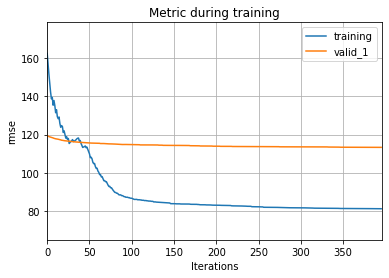

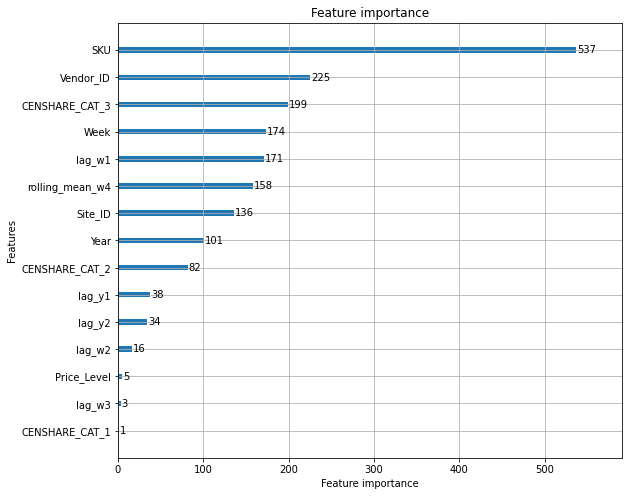

In [15]:
for week, year in splits:
    print(f'****** {year}W{week} ******')
    
    mod = lgb.Booster(model_file=path_models + f'gbm_{year}w{week}.txt')
    evals = pickle.load(open(path_models + f'evals_result_{year}w{week}.pkl', 'rb'))

    ax = lgb.plot_metric(evals)
    plt.show()
    
    ax = lgb.plot_importance(mod, figsize=(10,8))
    plt.gcf().subplots_adjust(left=0.2)
    plt.show()
    